In [75]:
# Data Manipulation
import numpy as np
import pandas as pd
import os
# Visualization/Image Processing
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPooling2D, Dense, Activation, Dropout
from PIL import Image
# Other
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
import xml.etree.ElementTree as ET
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import imutils

In [76]:
#Codice per rendere l'immagine quadrata 
def make_square(im, fill_color=(0, 0, 0, 0)):
    x, y = im.shape[0], im.shape[1]
    size = max(x, y)
    BLACK = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im,int((size-y)/2),int((size-y)/2),int((size-x)/2),int((size-x)/2),cv2.BORDER_CONSTANT, value = BLACK)
    return new_im

In [88]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightl
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    #thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)[1]
    #thresh = cv2.erode(thresh, None, iterations=2)
    #thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image,extLeft,extRight,extTop,extBot

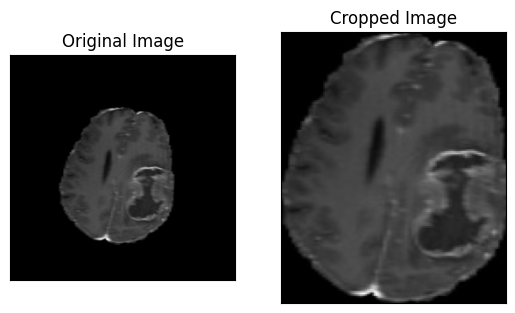

(256, 256, 3)
(155, 129, 3)
(56, 147)
(114, 60)
(185, 153)
(120, 215)


In [117]:
ex_img = cv2.imread('./axial_t1wce_2_class/images/test/00018_117.jpg')
ex_new_img,extLeft,extRight,extTop,extBot = crop_brain_contour(ex_img, True)
print(ex_img.shape)
print(ex_new_img.shape)
print(extLeft)
print(extTop)
print(extRight)
print(extBot)


In [127]:
#Bounding box with one tumor
lab = ['axial_t1wce_2_class','coronal_t1wce_2_class', 'sagittal_t1wce_2_class']
X_train = []
bb = []
count = 0;
temp_array  = []
extLeft_coords_x = []
extLeft_coords_y = []
extRight_coords_x = []
extRight_coords_y = []
extTop_coords_x = []
extTop_coords_y = []
extBot_coords_x = []
extBot_coords_y = []
images_width = []
images_height = []


extLeft_coords_x_test = []
extLeft_coords_y_test = []
extRight_coords_x_test = []
extRight_coords_y_test = []
extTop_coords_x_test = []
extTop_coords_y_test = []
extBot_coords_x_test = []
extBot_coords_y_test = []
images_width_test = []
images_height_test = []
width_new_im = []
height_new_im = []
traslazione_x_test = []
traslazione_y_test = []

image_size = 180

for i in lab:
    folderPath = os.path.join('./',i,'images','train')
    for j in tqdm(os.listdir(folderPath)):
        #load the image
        img = cv2.imread(os.path.join(folderPath,j))
        images_width.append(img.shape[1])
        images_height.append(img.shape[0])
        # crop the brain and ignore the unnecessary rest part of the image
        image,extLeft,extRight,extTop,extBot = crop_brain_contour(img,False)
        extLeft_coords_x.append(extLeft[0])
        extLeft_coords_y.append(extLeft[1])
        extRight_coords_x.append(extRight[0])
        extRight_coords_y.append(extRight[1])
        extTop_coords_x.append(extTop[0])
        extTop_coords_y.append(extTop[1])
        extBot_coords_x.append(extBot[0])
        extBot_coords_y.append(extBot[1])
        # resize image
        #image = cv2.resize(image, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)
        #if img.shape[0] != img.shape[1]:
            #img = make_square(img, fill_color=(0, 0, 0, 0))
        #img = cv2.resize(img,(image_size, image_size))
        X_train.append(image)
image_index = 0
bb_train = np.zeros((len(X_train),4))
for i in lab:
    labelsPath = os.path.join('./',i,'labels','train')
    for j in tqdm(os.listdir(labelsPath)):
        with open(os.path.join(labelsPath,j), encoding="utf-8") as f:
            for line in f:
                num = list(map(float,line.split(" ")))
                temp_array = []
                for k in num:
                    temp_array.append(k)
                temp_array.pop(0)
                temp_array[0] = temp_array[0]*images_width[count]
                temp_array[0] = temp_array[0]- ((extRight_coords_x[count] - extLeft_coords_x[count]))
                temp_array[0] = temp_array[0]*image_size
                temp_array[1] = temp_array[1]*images_height[count]
                temp_array[1] = temp_array[1]-(extBot_coords_y[count]-extTop_coords_y[count])
                temp_array[1] = temp_array[1]*image_size
                #print(temp_array)
                bb_train[image_index] = np.array([temp_array])
                #print(bb_train[image_index])
            image_index += 1
            count += 1
X_test = []
for i in lab:
    folderPath = os.path.join('./',i,'images','test')
    for j in tqdm(os.listdir(folderPath)):
        #load the image
        img = cv2.imread(os.path.join(folderPath,j))
        images_width_test.append(img.shape[1])
        images_height_test.append(img.shape[0])
        # crop the brain and ignore the unnecessary rest part of the image
        image_test,extLeft_test,extRight_test,extTop_test,extBot_test = crop_brain_contour(img,False)
        extLeft_coords_x_test.append(extLeft_test[0])
        extLeft_coords_y_test.append(extLeft_test[1])
        extRight_coords_x_test.append(extRight_test[0])
        extRight_coords_y_test.append(extRight_test[1])
        extTop_coords_x_test.append(extTop_test[0])
        extTop_coords_y_test.append(extTop_test[1])
        extBot_coords_x_test.append(extBot_test[0])
        extBot_coords_y_test.append(extBot_test[1])
        # resize image
        image_test = cv2.resize(image_test, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)
        #if img.shape[0] != img.shape[1]:
            #img = make_square(img, fill_color=(0, 0, 0, 0))
        #img = cv2.resize(img,(image_size, image_size))
        X_test.append(image_test)

image_index = 0
count_test = 0;
bb_test = np.zeros((len(X_test),4))
for i in lab:
    labelsPath = os.path.join('./',i,'labels','test')
    for j in tqdm(os.listdir(labelsPath)):
        with open(os.path.join(labelsPath,j), encoding="utf-8") as f:
            for line in f:
                num = list(map(float,line.split(" ")))
                temp_array = []
                for k in num:
                    temp_array.append(k)
                temp_array.pop(0)
                #width_new_im.append(extRight_coords_x_test[count_test]-extLeft_coords_x_test[count_test])
                #height_new_im.append(extBot_coords_y_test[count_test]-extTop_coords_y_test[count_test])
                
                
                temp_array[0] = temp_array[0]*images_width_test[count_test] #centro x immagine originale
                temp_array[0] = temp_array[0]-extLeft_coords_x_test[count_test]
                temp_array[0] = (temp_array[0]/(extRight_coords_x_test[count_test]-extLeft_coords_x_test[count_test]))*image_size
                
                temp_array[1] = temp_array[1]*images_height_test[count_test]
                temp_array[1] = temp_array[1]-extTop_coords_y_test[count_test]
                temp_array[1] = (temp_array[1]/(extBot_coords_y_test[count_test]-extTop_coords_y_test[count_test]))*image_size
                
                temp_array[2] = temp_array[2]*(images_width_test[count_test])
                temp_array[2] = (temp_array[2]/(extRight_coords_x_test[count_test]-extLeft_coords_x_test[count_test]))*image_size
                
                
                temp_array[3] = temp_array[3]*(images_height_test[count_test])
                temp_array[3] = (temp_array[3]/(extBot_coords_y_test[count_test]-extTop_coords_y_test[count_test]))*image_size                 
            
                bb_test[image_index] = np.array([temp_array])
                #print(bb_test[image_index])
            image_index += 1
            count_test += 1
print(bb_test[30])
print(extRight_coords_x_test[30])
print(extLeft_coords_x_test[30])


100%|████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 3051.89it/s]

[124.42452099  66.77324418  27.7127405   30.13654925]
383
141


([], [])

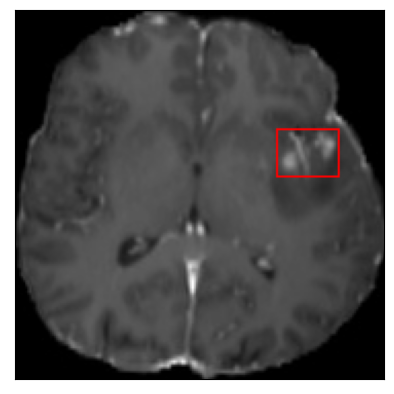

In [130]:
if len(bb_test[28]) == 4: #in rosso
    xmin, ymin, width, height = bb_test[28]
    img = cv2.rectangle(X_test[28], (int(xmin-width/2), int(ymin-height/2)), (int(xmin+width/2), int(ymin+height/2)), (255, 0, 0), 1)

plt.imshow(img)
plt.xticks([])
plt.yticks([])

In [12]:
len(X_test[46])

180

In [6]:
#prepare dataset 
train_dataset = ImageDataGenerator()
val_dataset = ImageDataGenerator()

In [7]:
#array conversion
X_train = np.array(X_train)
X_test = np.array(X_test)

In [8]:
#Shuffle
X_train, bb_train = shuffle(X_train, bb_train)

In [9]:
#Validation set created
X_train, X_val, bb_train, bb_val = train_test_split(X_train, bb_train, test_size = 0.1, shuffle = False)

In [10]:
tf.keras.backend.set_image_data_format('channels_last')
BATCH_SIZE = 16
save_path = os.path.join('./', 'model_from_scratch')
train_dataset = train_dataset.flow(X_train, bb_train, batch_size = BATCH_SIZE)
val_dataset = val_dataset.flow(X_val, bb_val, batch_size = BATCH_SIZE)

In [9]:
#Data augmentation
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        #layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2)
    ],
    name="img_augmentation",
)

In [ ]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [81]:
# Creating a Sequential model
model = Sequential()

# 1st Convolution Layer
model.add(Conv2D(filters=96, kernel_size=(11,11), input_shape=(227, 227, 3), strides=(4,4), padding='valid'))
# Normalization
model.add(BatchNormalization())
# Activation Function
model.add(Activation('relu'))
# Max-Pooling
model.add(MaxPooling2D((3,3), strides=(2,2), padding='valid'))

# 2nd Convolution Layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'))
# Normalization
model.add(BatchNormalization())
# Activation Function
model.add(Activation('relu'))
# Max-Pooling
model.add(MaxPooling2D((3,3), strides=(2,2), padding='valid'))

# 3rd Convolution Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), padding='same'))
# Normalization
model.add(BatchNormalization())
# Activation Function
model.add(Activation('relu'))

# 4th Convolution Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), padding='same'))
# Normalization
model.add(BatchNormalization())
# Activation Function
model.add(Activation('relu'))

# 5th Convolution Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
# Normalization
model.add(BatchNormalization())
# Activation Function
model.add(Activation('relu'))
# Max-Pooling
model.add(MaxPooling2D((3,3), strides=(2,2), padding='valid'))

# Flattening before passing to the Dense layer
model.add(Flatten())

# 1st Dense Layer
model.add(Dense(4096))
# Dropout
model.add(Dropout(0.5))
# Normalization
model.add(BatchNormalization())
# Activation Function
model.add(Activation('relu'))

# 2nd Dense Layer
model.add(Dense(4096))
# Dropout
model.add(Dropout(0.5))
# Normalization
model.add(BatchNormalization())
# Activation Function
model.add(Activation('relu'))

# Output softmax Layer
model.add(Dense(4))
# Activation Function
model.add(Activation('softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_164 (Conv2D)         (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_55 (Bat  (None, 55, 55, 96)       384       
 chNormalization)                                                
                                                                 
 activation_30 (Activation)  (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_165 (Conv2D)         (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_56 (Bat  (None, 27, 27, 256)     

In [82]:
# declaring the input layer
# In the original paper the network consisted of only one channel.
inputs = layers.Input(shape=(572, 572, 1))
# first part of the U - contracting part
c0 = layers.Conv2D(64, activation='relu', kernel_size=3)(inputs)
c1 = layers.Conv2D(64, activation='relu', kernel_size=3)(c0)  # This layer for concatenating in the expansive part
c2 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c1)

c3 = layers.Conv2D(128, activation='relu', kernel_size=3)(c2)
c4 = layers.Conv2D(128, activation='relu', kernel_size=3)(c3)  # This layer for concatenating in the expansive part
c5 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c4)

c6 = layers.Conv2D(256, activation='relu', kernel_size=3)(c5)
c7 = layers.Conv2D(256, activation='relu', kernel_size=3)(c6)  # This layer for concatenating in the expansive part
c8 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c7)

c9 = layers.Conv2D(512, activation='relu', kernel_size=3)(c8)
c10 = layers.Conv2D(512, activation='relu', kernel_size=3)(c9)  # This layer for concatenating in the expansive part
c11 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c10)

c12 = layers.Conv2D(1024, activation='relu', kernel_size=3)(c11)
c13 = layers.Conv2D(1024, activation='relu', kernel_size=3, padding='valid')(c12)

# We will now start the second part of the U - expansive part
t01 = layers.Conv2DTranspose(512, kernel_size=2, strides=(2, 2), activation='relu')(c13)
crop01 = layers.Cropping2D(cropping=(4, 4))(c10)

concat01 = layers.concatenate([t01, crop01], axis=-1)

c14 = layers.Conv2D(512, activation='relu', kernel_size=3)(concat01)
c15 = layers.Conv2D(512, activation='relu', kernel_size=3)(c14)

t02 = layers.Conv2DTranspose(256, kernel_size=2, strides=(2, 2), activation='relu')(c15)
crop02 = layers.Cropping2D(cropping=(16, 16))(c7)

concat02 = layers.concatenate([t02, crop02], axis=-1)

c16 = layers.Conv2D(256, activation='relu', kernel_size=3)(concat02)
c17 = layers.Conv2D(256, activation='relu', kernel_size=3)(c16)

t03 = layers.Conv2DTranspose(128, kernel_size=2, strides=(2, 2), activation='relu')(c17)
crop03 = layers.Cropping2D(cropping=(40, 40))(c4)

concat03 = layers.concatenate([t03, crop03], axis=-1)

c18 = layers.Conv2D(128, activation='relu', kernel_size=3)(concat03)
c19 = layers.Conv2D(128, activation='relu', kernel_size=3)(c18)

t04 = layers.Conv2DTranspose(64, kernel_size=2, strides=(2, 2), activation='relu')(c19)
crop04 = layers.Cropping2D(cropping=(88, 88))(c1)

concat04 = layers.concatenate([t04, crop04], axis=-1)

c20 = layers.Conv2D(64, activation='relu', kernel_size=3)(concat04)
c21 = layers.Conv2D(64, activation='relu', kernel_size=3)(c20)

model = layers.Conv2D(2, kernel_size=1)(c21)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Flatten()(model)
outputs = tf.keras.layers.Dense(4,name='coords')(model)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="u-netmodel")

model.summary()

Model: "u-netmodel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 572, 572, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_169 (Conv2D)            (None, 570, 570, 64  640         ['input_20[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_170 (Conv2D)            (None, 568, 568, 64  36928       ['conv2d_169[0][0]']             
                                )                                                        

                                8)                                                                
                                                                                                  
 conv2d_184 (Conv2D)            (None, 196, 196, 12  147584      ['conv2d_183[0][0]']             
                                8)                                                                
                                                                                                  
 conv2d_transpose_22 (Conv2DTra  (None, 392, 392, 64  32832      ['conv2d_184[0][0]']             
 nspose)                        )                                                                 
                                                                                                  
 cropping2d_19 (Cropping2D)     (None, 392, 392, 64  0           ['conv2d_170[0][0]']             
                                )                                                                 
          

In [83]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True
    ),
    ShowTestImages()
]

In [15]:
IMG_SIZE = 180
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
model = img_augmentation(inputs)
model = keras.applications.efficientnet.preprocess_input(model)
model = conv_base(model)
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Flatten()(model)
model = tf.keras.layers.Dense(4,name='coords')(model)
model = tf.keras.models.Model(inputs=inputs, outputs = model)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 img_augmentation (Sequentia  (None, 180, 180, 3)      0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 6, 6, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 flatten (Flatten)           (None, 1280)              0     

In [84]:
model.compile(
    loss={
        'coords': 'mae'
    },
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics={
        'coords': 'accuracy'
    }
)

In [85]:
model.fit(
        train_dataset,
        epochs=5,
        validation_data = val_dataset,
        callbacks = callbacks_list
        )

Epoch 1/5


UnimplementedError: Graph execution error:

Detected at node 'u-netmodel/conv2d_169/Relu' defined at (most recent call last):
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\alexi\AppData\Local\Temp\ipykernel_23016\572828044.py", line 1, in <module>
      model.fit(
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\layers\convolutional\base_conv.py", line 278, in call
      return self.activation(outputs)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\activations.py", line 311, in relu
      return backend.relu(x, alpha=alpha, max_value=max_value, threshold=threshold)
    File "c:\users\alexi\appdata\local\programs\python\python39\lib\site-packages\keras\backend.py", line 4992, in relu
      x = tf.nn.relu(x)
Node: 'u-netmodel/conv2d_169/Relu'
Fused conv implementation does not support grouped convolutions for now.
	 [[{{node u-netmodel/conv2d_169/Relu}}]] [Op:__inference_train_function_13429]

In [71]:
# Draw the predicted bounding boxes
def display_image(img, bbox_coords, pred_coords):
    if len(bbox_coords) == 4: #in rosso
        xmin, ymin, height, width = bbox_coords
        img = cv2.rectangle(img, (int(xmin-height/2), int(ymin-width/2)), (int(xmin+height/2), int(ymin+width/2)), (255, 0, 0), 1)
        
    if len(pred_coords) == 4: #in verde
        xmin1, ymin1, height1, width1 = pred_coords
        img = cv2.rectangle(img, (int(xmin1-height1/2), int(ymin1-width1/2)), (int(xmin1+height1/2), int(ymin1+width1/2)), (0, 255, 0), 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [72]:
#To test the model
def test_model(model):
    rand_index = np.random.randint(0, bb_test.shape[0])
    pred_bbox = model.predict(X_test)[rand_index]
    img_original = X_test[rand_index]
    img = img_original.copy()
    coords = bb_test[rand_index]
    #example, label = next(datagen)
    #X = example['image']
    #y = label['coords']
    #pred_bbox = model.predict(X)[0]
    #img = X[0]
    #gt_coords = y[0]
    
    display_image(img,bbox_coords = coords, pred_coords=pred_bbox)

def test(model):
    
    plt.figure(figsize=(15,7))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        test_model(model)    
    plt.show()

class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)
        

In [49]:
#Save model
model.save('./model_efficientNet')

INFO:tensorflow:Assets written to: ./model_efficientNet\assets


INFO:tensorflow:Assets written to: ./model_efficientNet\assets


In [37]:
#Save model
model.save('./model_from_scratch')

INFO:tensorflow:Assets written to: ./model_from_scratch\assets


INFO:tensorflow:Assets written to: ./model_from_scratch\assets


In [12]:
model = tf.keras.models.load_model('./model_efficientNet')

In [36]:
model = tf.keras.models.load_model('./model_from_scratch')

<AxesSubplot:>

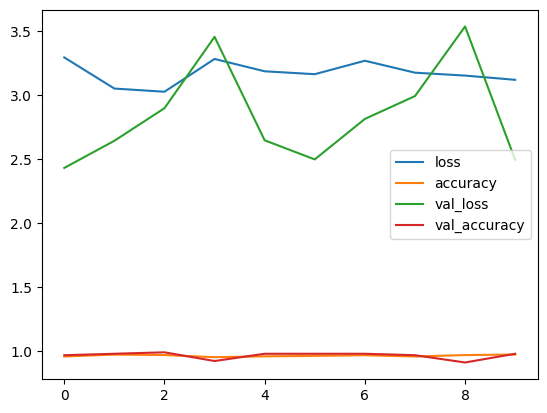

In [50]:
pd.DataFrame(model.history.history).plot()